In [1]:
import os
import logging
import sys
import random
import re
import glob
import os
import numpy
from matplotlib import pyplot as plt
import itertools
import numpy as np
import random
from random import shuffle
import pandas as pd
import graphviz

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

In [2]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    #fig = plt.figure()
    #plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('True class', fontsize=f_size + 1)
    plt.xlabel('Predicted class', fontsize=f_size + 1)
    plt.show()

In [3]:
dist_df = pd.read_csv('train_distance.csv', delimiter=',')
test_dist_df = pd.read_csv('test_distance.csv', delimiter=',')

l = dist_df.columns.get_loc('0')
r = dist_df.columns.get_loc('67')

X_dist = dist_df.iloc[:,l:r + 1]
test_X_dist = test_dist_df.iloc[:,l:r + 1]
y_dist = dist_df['mood.value']
test_y_dist = test_dist_df['mood.value']
y_dist = y_dist.astype('int')
test_y_dist = test_y_dist.astype('int')

In [ ]:
!pip install catboost

In [5]:
from catboost import CatBoostClassifier

In [ ]:
cat = CatBoostClassifier()
cat.fit(X_dist, y_dist)

              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.83      0.95      0.88        20
           2       0.62      0.65      0.63        20
           3       0.75      0.90      0.82        20
           4       0.90      0.95      0.93        20
           5       1.00      0.85      0.92        20
           6       0.73      0.55      0.63        20

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.78       140
weighted avg       0.79      0.79      0.78       140



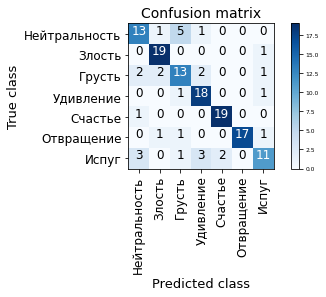

In [7]:
best = cat

print(classification_report(test_y_dist, best.predict(test_X_dist)))
conf_matr = confusion_matrix(test_y_dist, best.predict(test_X_dist))
plot_confusion_matrix(conf_matr, ['Нейтральность', 'Злость', 'Грусть', 'Удивление', 'Счастье', 'Отвращение', 'Испуг'], f_size=12)

In [9]:
from lightgbm import LGBMClassifier

In [ ]:
model = LGBMClassifier()

params = {'boosting_type': ['gbdt', 'rf'],
          'max_depth': [-1, 50, 100, 20]
}

clf = GridSearchCV(model, params, scoring='f1_macro', verbose=3, n_jobs=-1)

clf.fit(X_dist, y_dist)

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.86      0.90      0.88        20
           2       0.59      0.65      0.62        20
           3       0.78      0.90      0.84        20
           4       0.95      0.95      0.95        20
           5       0.85      0.85      0.85        20
           6       0.72      0.65      0.68        20

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.78       140
weighted avg       0.79      0.79      0.78       140



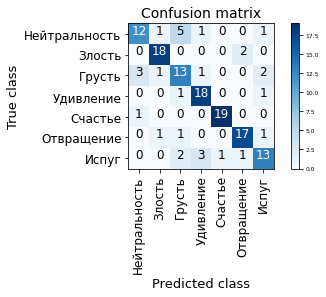

In [11]:
best = clf

print(classification_report(test_y_dist, best.predict(test_X_dist)))
conf_matr = confusion_matrix(test_y_dist, best.predict(test_X_dist))
plot_confusion_matrix(conf_matr, ['Нейтральность', 'Злость', 'Грусть', 'Удивление', 'Счастье', 'Отвращение', 'Испуг'], f_size=12)

In [12]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

clf1 = GradientBoostingClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
clf2 = XGBClassifier(max_depth=4)
clf3 = LinearSVC(dual=True, loss='squared_hinge', max_iter=1500, multi_class='ovr', penalty='l2', random_state=0)
eclf1 = VotingClassifier(estimators=[('gb', clf1), ('xgb', clf2), ('lsvc', clf3)], voting='hard')
eclf1 = eclf1.fit(X_dist, y_dist)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.91      1.00      0.95        20
           2       0.70      0.70      0.70        20
           3       0.69      0.90      0.78        20
           4       0.90      0.95      0.93        20
           5       0.95      0.90      0.92        20
           6       0.83      0.50      0.62        20

    accuracy                           0.81       140
   macro avg       0.82      0.81      0.81       140
weighted avg       0.82      0.81      0.81       140



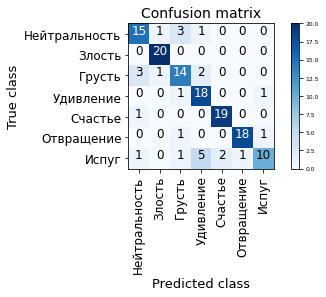

In [13]:
best = eclf1

print(classification_report(test_y_dist, best.predict(test_X_dist)))
conf_matr = confusion_matrix(test_y_dist, best.predict(test_X_dist))
plot_confusion_matrix(conf_matr, ['Нейтральность', 'Злость', 'Грусть', 'Удивление', 'Счастье', 'Отвращение', 'Испуг'], f_size=12)

In [ ]:
clf = StackingClassifier(estimators=[('gb', clf1), ('xgb', clf2), ('lsvc', clf3), ('cat', cat)])
clf.fit(X_dist, y_dist)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.95      0.95      0.95        20
           2       0.75      0.75      0.75        20
           3       0.83      0.95      0.88        20
           4       0.95      0.95      0.95        20
           5       0.90      0.90      0.90        20
           6       0.88      0.70      0.78        20

    accuracy                           0.86       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140



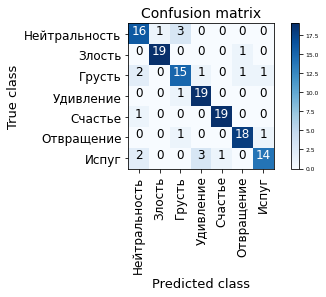

In [18]:
best = clf

print(classification_report(test_y_dist, best.predict(test_X_dist)))
conf_matr = confusion_matrix(test_y_dist, best.predict(test_X_dist))
plot_confusion_matrix(conf_matr, ['Нейтральность', 'Злость', 'Грусть', 'Удивление', 'Счастье', 'Отвращение', 'Испуг'], f_size=12)